## K-means clustering performed on all nine channels (min-max calculated for each channel, rescaled data calculated for each channel)

In [5]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

def load_and_concat_datasets(parent_folder, channels):
    datasets = [
        xr.open_dataset(f'{parent_folder}/{channel}')[channel.split('.')[0]]
        for channel in channels
    ]
    ds_combined = xr.concat(datasets, dim='channels')
    return ds_combined

def find_min_max_across_channels(ds_combined):
    mins = [np.nanmin(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    maxs = [np.nanmax(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    return mins, maxs

def rescale_data(data, channel_min, channel_max):
    return 255 * (data - channel_min) / (channel_max - channel_min)

def get_combined_labels(cloud, clear, ice):
    labels = np.zeros(cloud.shape[0], dtype=int)
    labels[cloud == 1] = 0  # 0 represents cloud
    labels[clear == 1] = 1  # 1 represents clear
    labels[ice == 1] = 2    # 2 represents ice
    return labels

def perform_kmeans_and_evaluation(channels, parent_folder):
    ds_combined = load_and_concat_datasets(parent_folder, channels)

    mins, maxs = find_min_max_across_channels(ds_combined)

    rescaled_data_list = [xr.apply_ufunc(
        rescale_data,
        ds_combined[i],
        kwargs={'channel_min': mins[i], 'channel_max': maxs[i]},
        vectorize=True
    ) for i in range(ds_combined.shape[0])]

    rescaled_data = xr.concat(rescaled_data_list, dim='channels')

    n_samples = rescaled_data.shape[1] * rescaled_data.shape[2]
    n_features = rescaled_data.shape[0]
    rescaled_array = rescaled_data.values.reshape(n_samples, n_features)

    nan_mask = np.isnan(rescaled_array)
    rescaled_array_clean = rescaled_array[~nan_mask.any(axis=1)]

    n_clusters = 3
    kmeans = KMeans(n_clusters=n_clusters).fit(rescaled_array_clean)
    cluster_labels_clean = np.full(n_samples, np.nan)
    cluster_labels_clean[~nan_mask.any(axis=1)] = kmeans.labels_

    cloud_labels = xr.open_dataset(f'{parent_folder}/cloud_labels.nc')['Cloud']
    clear_labels = xr.open_dataset(f'{parent_folder}/clear_labels.nc')['Clear']
    ice_labels = xr.open_dataset(f'{parent_folder}/ice_labels.nc')['Ice']

    for label in [cloud_labels, clear_labels, ice_labels]:
        assert ds_combined.coords == label.coords, 'Mismatch between data coordinates and label coordinates'

    cloud_labels_clean = cloud_labels.values.flatten()
    clear_labels_clean = clear_labels.values.flatten()
    ice_labels_clean = ice_labels.values.flatten()

    labels_common_mask = ~np.isnan(cluster_labels_clean) & \
                         ~np.isnan(cloud_labels_clean) & \
                         ~np.isnan(clear_labels_clean) & \
                         ~np.isnan(ice_labels_clean)

    combined_labels_clean = get_combined_labels(cloud_labels_clean, clear_labels_clean, ice_labels_clean)
    combined_labels_clean_filtered = combined_labels_clean[labels_common_mask]
    cluster_labels_clean_filtered = cluster_labels_clean[labels_common_mask]

    conf_matrix = confusion_matrix(combined_labels_clean_filtered, cluster_labels_clean_filtered)
    accuracy = accuracy_score(combined_labels_clean_filtered, cluster_labels_clean_filtered)

    display_results(conf_matrix, accuracy, 'Combined')
    
    return ds_combined, cluster_labels_clean.reshape(ds_combined.shape[1:]), cloud_labels, clear_labels, ice_labels, kmeans, rescaled_array_clean

def display_results(matrix, accuracy, label_name):
    df = pd.DataFrame(matrix, 
                      columns=[f"Predicted {i}" for i in range(matrix.shape[1])], 
                      index=[f"Actual {i}" for i in range(matrix.shape[0])])
    print(f"Confusion Matrix - {label_name} Labels:")
    print(df)
    print(f"Accuracy - {label_name} Labels:", accuracy)
    print("\n" + "="*50 + "\n")

channels_radiance = ['S1_radiance_in.nc', 'S2_radiance_in.nc', 'S3_radiance_in.nc', 'S4_radiance_in.nc', 'S5_radiance_in.nc', 'S6_radiance_in.nc']
channels_thermal = ['S7_BT_in.nc', 'S8_BT_in.nc', 'S9_BT_in.nc']
channels = channels_radiance + channels_thermal

ds_combined, cluster_labels_clean, combined_labels, _, _, kmeans, rescaled_array_clean = perform_kmeans_and_evaluation(channels, '/Users/rashmilsinha/Downloads/Sentinel-lite/sentinel2/')

/Users/rashmilsinha/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Confusion Matrix - Combined Labels:
          Predicted 0  Predicted 1  Predicted 2
Actual 0       685906       671383       344665
Actual 1         5348         2595         8290
Actual 2        15412         4575        40424
Accuracy - Combined Labels: 0.4098312266178192




In [2]:
total_elements = np.prod(cluster_labels_clean.shape)
cloud_elements = np.sum(cluster_labels_clean == 0)
cloud_percentage = (cloud_elements / total_elements) * 100
print(f"Percentage of domain identified as cloud: {cloud_percentage:.2f}%")

total_elements = np.prod(cluster_labels_clean.shape)
clear_elements = np.sum(cluster_labels_clean == 1)
clear_percentage = (clear_elements / total_elements) * 100
print(f"Percentage of domain identified as clear: {clear_percentage:.2f}%")

total_elements = np.prod(cluster_labels_clean.shape)
ice_elements = np.sum(cluster_labels_clean == 2)
ice_percentage = (ice_elements / total_elements) * 100
print(f"Percentage of domain identified as ice: {ice_percentage:.2f}%")

Percentage of domain identified as cloud: 39.17%
Percentage of domain identified as clear: 37.84%
Percentage of domain identified as ice: 21.81%


## K-means clustering performed on all channels minus S7 (min-max calculated for each channel, rescaled data calculated for each channel)

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

def load_and_concat_datasets(parent_folder, channels):
    datasets = [
        xr.open_dataset(f'{parent_folder}/{channel}')[channel.split('.')[0]]
        for channel in channels
    ]
    ds_combined = xr.concat(datasets, dim='channels')
    return ds_combined

def find_min_max_across_channels(ds_combined):
    mins = [np.nanmin(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    maxs = [np.nanmax(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    return mins, maxs

def rescale_data(data, channel_min, channel_max):
    return 255 * (data - channel_min) / (channel_max - channel_min)

def get_combined_labels(cloud, clear, ice):
    labels = np.zeros(cloud.shape[0], dtype=int)
    labels[cloud == 1] = 0  # 0 represents cloud
    labels[clear == 1] = 1  # 1 represents clear
    labels[ice == 1] = 2    # 2 represents ice
    return labels

def perform_kmeans_and_evaluation(channels, parent_folder):
    ds_combined = load_and_concat_datasets(parent_folder, channels)

    mins, maxs = find_min_max_across_channels(ds_combined)

    rescaled_data_list = [xr.apply_ufunc(
        rescale_data,
        ds_combined[i],
        kwargs={'channel_min': mins[i], 'channel_max': maxs[i]},
        vectorize=True
    ) for i in range(ds_combined.shape[0])]

    rescaled_data = xr.concat(rescaled_data_list, dim='channels')

    n_samples = rescaled_data.shape[1] * rescaled_data.shape[2]
    n_features = rescaled_data.shape[0]
    rescaled_array = rescaled_data.values.reshape(n_samples, n_features)

    nan_mask = np.isnan(rescaled_array)
    rescaled_array_clean = rescaled_array[~nan_mask.any(axis=1)]

    n_clusters = 3
    kmeans = KMeans(n_clusters=n_clusters).fit(rescaled_array_clean)
    cluster_labels_clean = np.full(n_samples, np.nan)
    cluster_labels_clean[~nan_mask.any(axis=1)] = kmeans.labels_

    cloud_labels = xr.open_dataset(f'{parent_folder}/cloud_labels.nc')['Cloud']
    clear_labels = xr.open_dataset(f'{parent_folder}/clear_labels.nc')['Clear']
    ice_labels = xr.open_dataset(f'{parent_folder}/ice_labels.nc')['Ice']

    for label in [cloud_labels, clear_labels, ice_labels]:
        assert ds_combined.coords == label.coords, 'Mismatch between data coordinates and label coordinates'

    cloud_labels_clean = cloud_labels.values.flatten()
    clear_labels_clean = clear_labels.values.flatten()
    ice_labels_clean = ice_labels.values.flatten()

    labels_common_mask = ~np.isnan(cluster_labels_clean) & \
                         ~np.isnan(cloud_labels_clean) & \
                         ~np.isnan(clear_labels_clean) & \
                         ~np.isnan(ice_labels_clean)

    combined_labels_clean = get_combined_labels(cloud_labels_clean, clear_labels_clean, ice_labels_clean)
    combined_labels_clean_filtered = combined_labels_clean[labels_common_mask]
    cluster_labels_clean_filtered = cluster_labels_clean[labels_common_mask]

    conf_matrix = confusion_matrix(combined_labels_clean_filtered, cluster_labels_clean_filtered)
    accuracy = accuracy_score(combined_labels_clean_filtered, cluster_labels_clean_filtered)

    display_results(conf_matrix, accuracy, 'Combined')
    
    return ds_combined, cluster_labels_clean.reshape(ds_combined.shape[1:]), cloud_labels, clear_labels, ice_labels, kmeans, rescaled_array_clean

def display_results(matrix, accuracy, label_name):
    df = pd.DataFrame(matrix, 
                      columns=[f"Predicted {i}" for i in range(matrix.shape[1])], 
                      index=[f"Actual {i}" for i in range(matrix.shape[0])])
    print(f"Confusion Matrix - {label_name} Labels:")
    print(df)
    print(f"Accuracy - {label_name} Labels:", accuracy)
    print("\n" + "="*50 + "\n")

channels_radiance = ['S1_radiance_in.nc', 'S2_radiance_in.nc', 'S3_radiance_in.nc', 'S4_radiance_in.nc', 'S5_radiance_in.nc', 'S6_radiance_in.nc']
channels_thermal = ['S8_BT_in.nc', 'S9_BT_in.nc']
channels = channels_radiance + channels_thermal

ds_combined, cluster_labels_clean, combined_labels, _, _, kmeans, rescaled_array_clean = perform_kmeans_and_evaluation(channels, '/Users/rashmilsinha/Downloads/Sentinel-lite/sentinel2/')

/Users/rashmilsinha/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Confusion Matrix - Combined Labels:
          Predicted 0  Predicted 1  Predicted 2
Actual 0       716570       721933       264856
Actual 1         4240         5029         6834
Actual 2        13595         6184        40815
Accuracy - Combined Labels: 0.42830899702031844




In [2]:
total_elements = np.prod(cluster_labels_clean.shape)
cloud_elements = np.sum(cluster_labels_clean == 0)
cloud_percentage = (cloud_elements / total_elements) * 100
print(f"Percentage of domain identified as cloud: {cloud_percentage:.2f}%")

total_elements = np.prod(cluster_labels_clean.shape)
clear_elements = np.sum(cluster_labels_clean == 1)
clear_percentage = (clear_elements / total_elements) * 100
print(f"Percentage of domain identified as clear: {clear_percentage:.2f}%")

total_elements = np.prod(cluster_labels_clean.shape)
ice_elements = np.sum(cluster_labels_clean == 2)
ice_percentage = (ice_elements / total_elements) * 100
print(f"Percentage of domain identified as ice: {ice_percentage:.2f}%")

Percentage of domain identified as cloud: 40.80%
Percentage of domain identified as clear: 40.73%
Percentage of domain identified as ice: 17.36%


## K-means clustering performed on all channels minus S4 (min-max calculated for each channel, rescaled data calculated for each channel)

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

def load_and_concat_datasets(parent_folder, channels):
    datasets = [
        xr.open_dataset(f'{parent_folder}/{channel}')[channel.split('.')[0]]
        for channel in channels
    ]
    ds_combined = xr.concat(datasets, dim='channels')
    return ds_combined

def find_min_max_across_channels(ds_combined):
    mins = [np.nanmin(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    maxs = [np.nanmax(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    return mins, maxs

def rescale_data(data, channel_min, channel_max):
    return 255 * (data - channel_min) / (channel_max - channel_min)

def get_combined_labels(cloud, clear, ice):
    labels = np.zeros(cloud.shape[0], dtype=int)
    labels[cloud == 1] = 0  # 0 represents cloud
    labels[clear == 1] = 1  # 1 represents clear
    labels[ice == 1] = 2    # 2 represents ice
    return labels

def perform_kmeans_and_evaluation(channels, parent_folder):
    ds_combined = load_and_concat_datasets(parent_folder, channels)

    mins, maxs = find_min_max_across_channels(ds_combined)

    rescaled_data_list = [xr.apply_ufunc(
        rescale_data,
        ds_combined[i],
        kwargs={'channel_min': mins[i], 'channel_max': maxs[i]},
        vectorize=True
    ) for i in range(ds_combined.shape[0])]

    rescaled_data = xr.concat(rescaled_data_list, dim='channels')

    n_samples = rescaled_data.shape[1] * rescaled_data.shape[2]
    n_features = rescaled_data.shape[0]
    rescaled_array = rescaled_data.values.reshape(n_samples, n_features)

    nan_mask = np.isnan(rescaled_array)
    rescaled_array_clean = rescaled_array[~nan_mask.any(axis=1)]

    n_clusters = 3
    kmeans = KMeans(n_clusters=n_clusters).fit(rescaled_array_clean)
    cluster_labels_clean = np.full(n_samples, np.nan)
    cluster_labels_clean[~nan_mask.any(axis=1)] = kmeans.labels_

    cloud_labels = xr.open_dataset(f'{parent_folder}/cloud_labels.nc')['Cloud']
    clear_labels = xr.open_dataset(f'{parent_folder}/clear_labels.nc')['Clear']
    ice_labels = xr.open_dataset(f'{parent_folder}/ice_labels.nc')['Ice']

    for label in [cloud_labels, clear_labels, ice_labels]:
        assert ds_combined.coords == label.coords, 'Mismatch between data coordinates and label coordinates'

    cloud_labels_clean = cloud_labels.values.flatten()
    clear_labels_clean = clear_labels.values.flatten()
    ice_labels_clean = ice_labels.values.flatten()

    labels_common_mask = ~np.isnan(cluster_labels_clean) & \
                         ~np.isnan(cloud_labels_clean) & \
                         ~np.isnan(clear_labels_clean) & \
                         ~np.isnan(ice_labels_clean)

    combined_labels_clean = get_combined_labels(cloud_labels_clean, clear_labels_clean, ice_labels_clean)
    combined_labels_clean_filtered = combined_labels_clean[labels_common_mask]
    cluster_labels_clean_filtered = cluster_labels_clean[labels_common_mask]

    conf_matrix = confusion_matrix(combined_labels_clean_filtered, cluster_labels_clean_filtered)
    accuracy = accuracy_score(combined_labels_clean_filtered, cluster_labels_clean_filtered)

    display_results(conf_matrix, accuracy, 'Combined')
    
    return ds_combined, cluster_labels_clean.reshape(ds_combined.shape[1:]), cloud_labels, clear_labels, ice_labels, kmeans, rescaled_array_clean

def display_results(matrix, accuracy, label_name):
    df = pd.DataFrame(matrix, 
                      columns=[f"Predicted {i}" for i in range(matrix.shape[1])], 
                      index=[f"Actual {i}" for i in range(matrix.shape[0])])
    print(f"Confusion Matrix - {label_name} Labels:")
    print(df)
    print(f"Accuracy - {label_name} Labels:", accuracy)
    print("\n" + "="*50 + "\n")

channels_radiance = ['S1_radiance_in.nc', 'S2_radiance_in.nc', 'S3_radiance_in.nc', 'S5_radiance_in.nc', 'S6_radiance_in.nc']
channels_thermal = ['S7_BT_in.nc', 'S8_BT_in.nc', 'S9_BT_in.nc']
channels = channels_radiance + channels_thermal

ds_combined, cluster_labels_clean, combined_labels, _, _, kmeans, rescaled_array_clean = perform_kmeans_and_evaluation(channels, '/Users/rashmilsinha/Downloads/Sentinel-lite/sentinel2/')

/Users/rashmilsinha/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Confusion Matrix - Combined Labels:
          Predicted 0  Predicted 1  Predicted 2
Actual 0       660541       371316       671502
Actual 1         5067         6894         4142
Actual 2         4481        41299        14814
Accuracy - Combined Labels: 0.38327389700099324




In [2]:
total_elements = np.prod(cluster_labels_clean.shape)
cloud_elements = np.sum(cluster_labels_clean == 0)
cloud_percentage = (cloud_elements / total_elements) * 100
print(f"Percentage of domain identified as cloud: {cloud_percentage:.2f}%")

total_elements = np.prod(cluster_labels_clean.shape)
clear_elements = np.sum(cluster_labels_clean == 1)
clear_percentage = (clear_elements / total_elements) * 100
print(f"Percentage of domain identified as clear: {clear_percentage:.2f}%")

total_elements = np.prod(cluster_labels_clean.shape)
ice_elements = np.sum(cluster_labels_clean == 2)
ice_percentage = (ice_elements / total_elements) * 100
print(f"Percentage of domain identified as ice: {ice_percentage:.2f}%")

Percentage of domain identified as cloud: 37.23%
Percentage of domain identified as clear: 23.31%
Percentage of domain identified as ice: 38.36%


## K-means clustering performed on all channels minus S4 and S7 (min-max calculated for each channel, rescaled data calculated for each channel)

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

def load_and_concat_datasets(parent_folder, channels):
    datasets = [
        xr.open_dataset(f'{parent_folder}/{channel}')[channel.split('.')[0]]
        for channel in channels
    ]
    ds_combined = xr.concat(datasets, dim='channels')
    return ds_combined

def find_min_max_across_channels(ds_combined):
    mins = [np.nanmin(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    maxs = [np.nanmax(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    return mins, maxs

def rescale_data(data, channel_min, channel_max):
    return 255 * (data - channel_min) / (channel_max - channel_min)

def get_combined_labels(cloud, clear, ice):
    labels = np.zeros(cloud.shape[0], dtype=int)
    labels[cloud == 1] = 0  # 0 represents cloud
    labels[clear == 1] = 1  # 1 represents clear
    labels[ice == 1] = 2    # 2 represents ice
    return labels

def perform_kmeans_and_evaluation(channels, parent_folder):
    ds_combined = load_and_concat_datasets(parent_folder, channels)

    mins, maxs = find_min_max_across_channels(ds_combined)

    rescaled_data_list = [xr.apply_ufunc(
        rescale_data,
        ds_combined[i],
        kwargs={'channel_min': mins[i], 'channel_max': maxs[i]},
        vectorize=True
    ) for i in range(ds_combined.shape[0])]

    rescaled_data = xr.concat(rescaled_data_list, dim='channels')

    n_samples = rescaled_data.shape[1] * rescaled_data.shape[2]
    n_features = rescaled_data.shape[0]
    rescaled_array = rescaled_data.values.reshape(n_samples, n_features)

    nan_mask = np.isnan(rescaled_array)
    rescaled_array_clean = rescaled_array[~nan_mask.any(axis=1)]

    n_clusters = 3
    kmeans = KMeans(n_clusters=n_clusters).fit(rescaled_array_clean)
    cluster_labels_clean = np.full(n_samples, np.nan)
    cluster_labels_clean[~nan_mask.any(axis=1)] = kmeans.labels_

    cloud_labels = xr.open_dataset(f'{parent_folder}/cloud_labels.nc')['Cloud']
    clear_labels = xr.open_dataset(f'{parent_folder}/clear_labels.nc')['Clear']
    ice_labels = xr.open_dataset(f'{parent_folder}/ice_labels.nc')['Ice']

    for label in [cloud_labels, clear_labels, ice_labels]:
        assert ds_combined.coords == label.coords, 'Mismatch between data coordinates and label coordinates'

    cloud_labels_clean = cloud_labels.values.flatten()
    clear_labels_clean = clear_labels.values.flatten()
    ice_labels_clean = ice_labels.values.flatten()

    labels_common_mask = ~np.isnan(cluster_labels_clean) & \
                         ~np.isnan(cloud_labels_clean) & \
                         ~np.isnan(clear_labels_clean) & \
                         ~np.isnan(ice_labels_clean)

    combined_labels_clean = get_combined_labels(cloud_labels_clean, clear_labels_clean, ice_labels_clean)
    combined_labels_clean_filtered = combined_labels_clean[labels_common_mask]
    cluster_labels_clean_filtered = cluster_labels_clean[labels_common_mask]

    conf_matrix = confusion_matrix(combined_labels_clean_filtered, cluster_labels_clean_filtered)
    accuracy = accuracy_score(combined_labels_clean_filtered, cluster_labels_clean_filtered)

    display_results(conf_matrix, accuracy, 'Combined')
    
    return ds_combined, cluster_labels_clean.reshape(ds_combined.shape[1:]), cloud_labels, clear_labels, ice_labels, kmeans, rescaled_array_clean

def display_results(matrix, accuracy, label_name):
    df = pd.DataFrame(matrix, 
                      columns=[f"Predicted {i}" for i in range(matrix.shape[1])], 
                      index=[f"Actual {i}" for i in range(matrix.shape[0])])
    print(f"Confusion Matrix - {label_name} Labels:")
    print(df)
    print(f"Accuracy - {label_name} Labels:", accuracy)
    print("\n" + "="*50 + "\n")

channels_radiance = ['S1_radiance_in.nc', 'S2_radiance_in.nc', 'S3_radiance_in.nc', 'S5_radiance_in.nc', 'S6_radiance_in.nc']
channels_thermal = ['S8_BT_in.nc', 'S9_BT_in.nc']
channels = channels_radiance + channels_thermal

ds_combined, cluster_labels_clean, combined_labels, _, _, kmeans, rescaled_array_clean = perform_kmeans_and_evaluation(channels, '/Users/rashmilsinha/Downloads/Sentinel-lite/sentinel2/')

/Users/rashmilsinha/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Confusion Matrix - Combined Labels:
          Predicted 0  Predicted 1  Predicted 2
Actual 0       689323       715119       299841
Actual 1         3737         6467         5820
Actual 2         4368        15427        40822
Accuracy - Combined Labels: 0.41361225970338994




In [2]:
total_elements = np.prod(cluster_labels_clean.shape)
cloud_elements = np.sum(cluster_labels_clean == 0)
cloud_percentage = (cloud_elements / total_elements) * 100
print(f"Percentage of domain identified as cloud: {cloud_percentage:.2f}%")

total_elements = np.prod(cluster_labels_clean.shape)
clear_elements = np.sum(cluster_labels_clean == 1)
clear_percentage = (clear_elements / total_elements) * 100
print(f"Percentage of domain identified as clear: {clear_percentage:.2f}%")

total_elements = np.prod(cluster_labels_clean.shape)
ice_elements = np.sum(cluster_labels_clean == 2)
ice_percentage = (ice_elements / total_elements) * 100
print(f"Percentage of domain identified as ice: {ice_percentage:.2f}%")

Percentage of domain identified as cloud: 38.75%
Percentage of domain identified as clear: 40.95%
Percentage of domain identified as ice: 19.25%


/Users/rashmilsinha/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


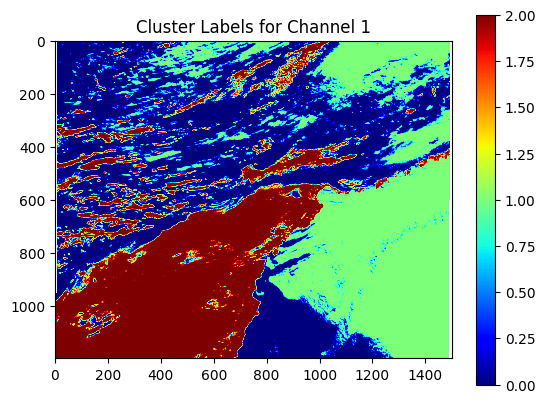

/Users/rashmilsinha/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


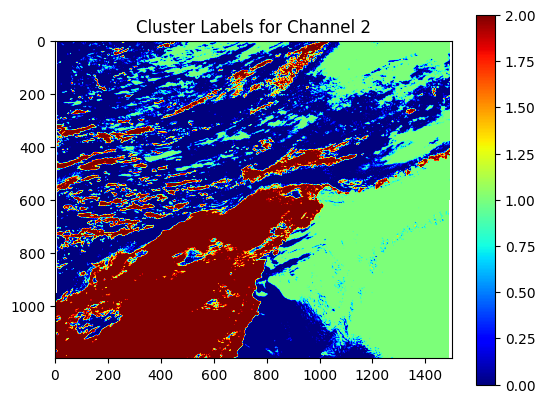

/Users/rashmilsinha/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


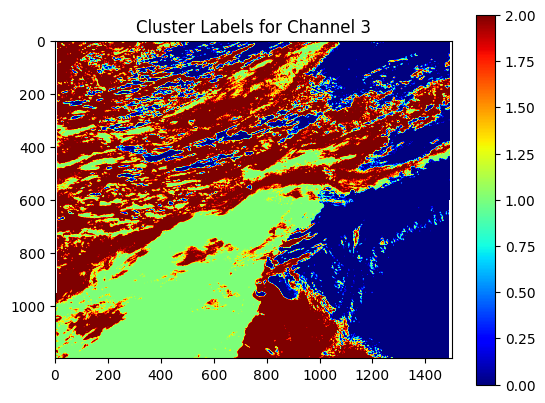

/Users/rashmilsinha/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


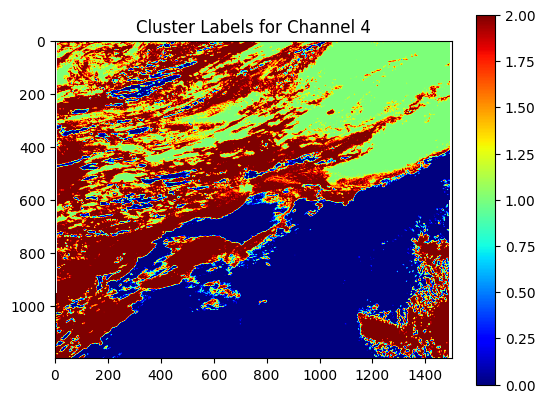

/Users/rashmilsinha/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


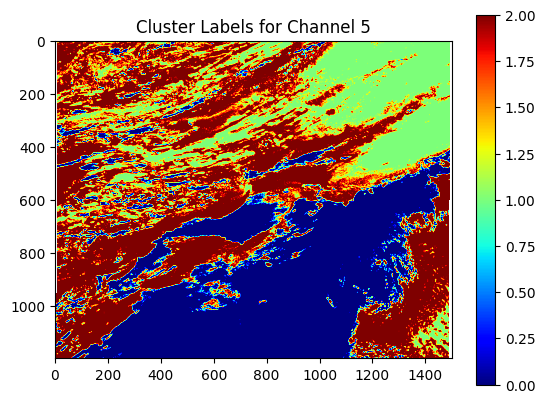

/Users/rashmilsinha/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


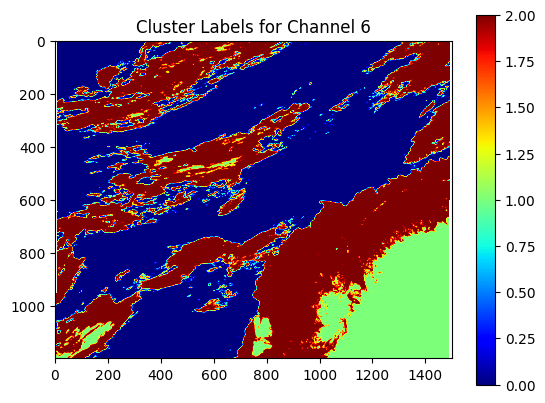

/Users/rashmilsinha/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


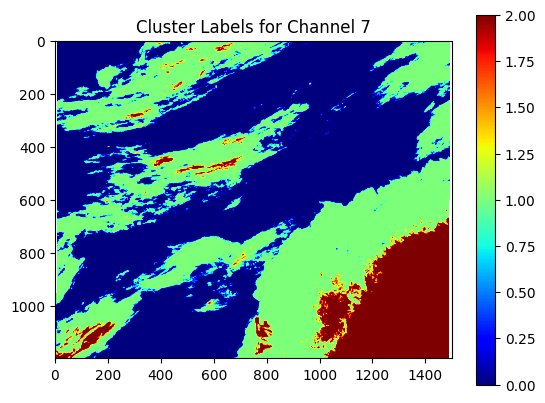

In [3]:
for idx in range(ds_combined.shape[0]):
    data_channel = ds_combined[idx].values.flatten()
    nan_mask = np.isnan(data_channel)
    data_channel_clean = data_channel[~nan_mask]
    
    kmeans_channel = KMeans(n_clusters=3).fit(data_channel_clean.reshape(-1, 1))
    cluster_labels_channel = np.full(data_channel.shape, np.nan)
    cluster_labels_channel[~nan_mask] = kmeans_channel.labels_
    
    plt.imshow(cluster_labels_channel.reshape(ds_combined.shape[1:]), cmap='jet')
    plt.title(f"Cluster Labels for Channel {idx + 1}")
    plt.colorbar()
    plt.show()


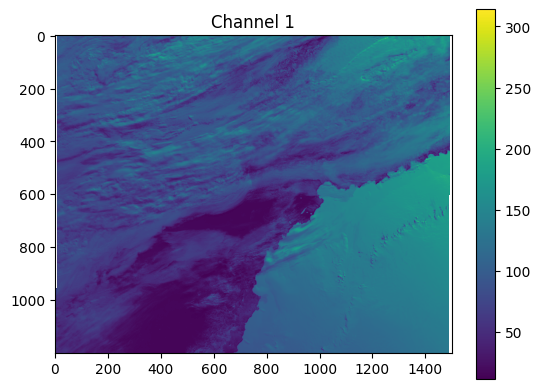

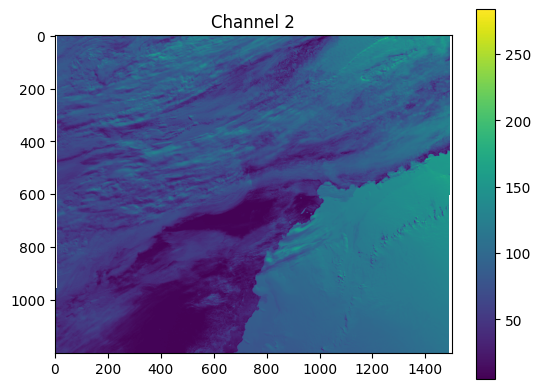

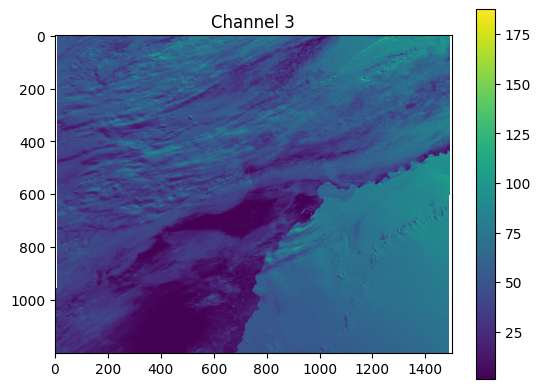

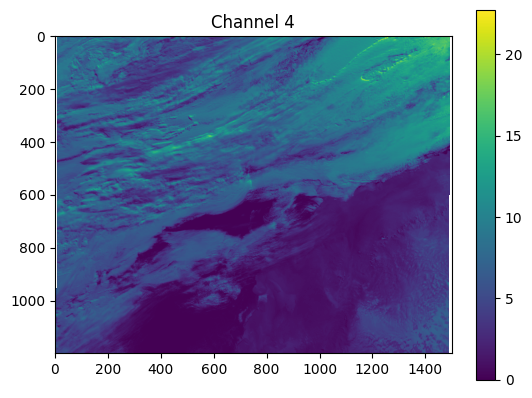

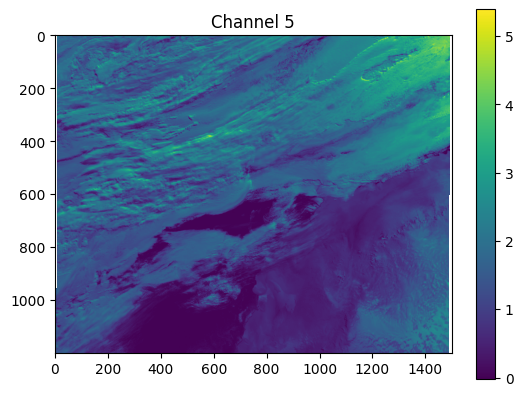

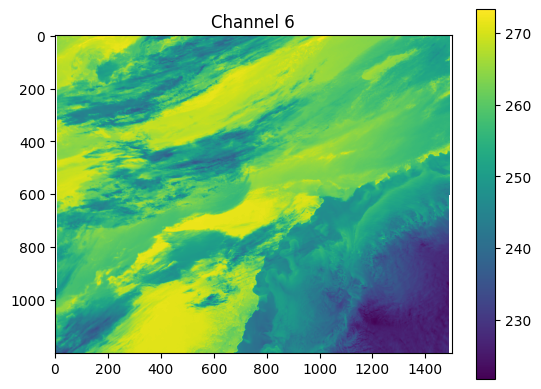

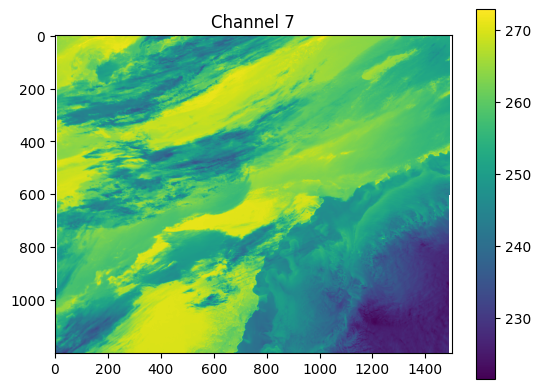

In [4]:
for idx in range(ds_combined.shape[0]):
    plt.imshow(ds_combined[idx])
    plt.title(f"Channel {idx + 1}")
    plt.colorbar()
    plt.show()
